## Analyze whether SNWD varies more from year to year or from place to place.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math

In [5]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [6]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [7]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBBSBS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
947
+------------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|           coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|              res_4|          res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|2266.6336758751727|-357.1065299335642|-917.3986444722822| 154.24352

In [8]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'coeff_4', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_4', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [9]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


,station,year,coeff_2
0,US1MECM0020,2011.0,-357.106530
1,USC00172238,2008.0,747.516516
2,USC00274475,1952.0,446.106981
3,USC00278612,1987.0,-563.721201
4,USC00278612,1976.0,-765.173177


In [10]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.head(10)

station,CA008206500,US1MECM0007,US1MECM0018,US1MECM0020,US1MECM0023,US1NHBK0002,US1NHCR0001,US1NHMR0025,US1NHRC0018,USC00170409,...,USC00279278,USC00279740,USC00279865,USC00279866,USC00279903,USW00004743,USW00014611,USW00014710,USW00014745,USW00014764
year,,,,,,,,,,,,,,,,,,,,,
1893.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1896.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1905.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the first eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [12]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

total RMS                   =  977.398862638
RMS removing mean-by-station=  930.247992826
RMS removing mean-by-year   =  496.582543868


In [19]:
tbl_minus_station.head(2)

station,CA008206500,US1MECM0007,US1MECM0018,US1MECM0020,US1MECM0023,US1NHBK0002,US1NHCR0001,US1NHMR0025,US1NHRC0018,USC00170409,...,USC00279278,USC00279740,USC00279865,USC00279866,USC00279903,USW00004743,USW00014611,USW00014710,USW00014745,USW00014764
year,,,,,,,,,,,,,,,,,,,,,
1893.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

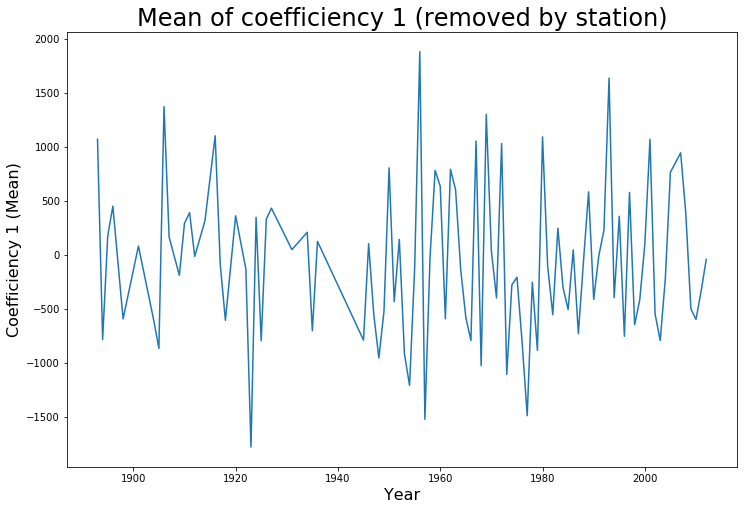

In [35]:
plt.figure(figsize=(12,8))
plt.plot(tbl_minus_station.mean(axis=1))
plt.title('Mean of coefficiency 1 (removed by station)', fontsize=24)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Coefficiency 1 (Mean)', fontsize=16)

In [38]:
tbl_minus_station.mean(axis=0).values

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.84217094e-14,   0.00000000e+00,   2.84217094e-14,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   6.68746104e-15,
        -9.36244546e-14,   0.00000000e+00,   0.00000000e+00,
        -1.13686838e-14,   2.06703341e-14,   5.68434189e-14,
         1.35003120e-13,   2.08425869e-14,  -7.57912251e-14,
        -2.84217094e-14,   8.84230960e-14,   4.54747351e-14,
        -1.42108547e-14,   0.00000000e+00,   3.52821221e-14,
         2.84217094e-14,  -1.42108547e-14,  -3.78956126e-14,
        -4.87229305e-14,  -7.10542736e-15,   1.51582450e-13,
         2.27373675e-14,  -6.63173220e-14,   0.00000000e+00,
         0.00000000e+00,   8.52651283e-14,  -1.26318709e-14,
         4.26325641e-14,  -1.89478063e-14,   0.00000000e+00,
         0.00000000e+00,   5.68434189e-14,   3.78956126e-14,
        -2.84217094e-14,  -6.49639073e-14,   0.00000000e+00,
        -1.42108547e-14,

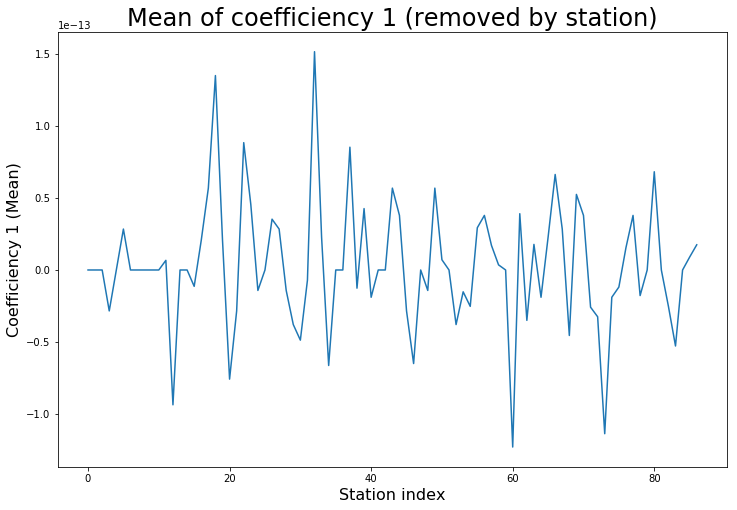

In [40]:
plt.figure(figsize=(12,8))
plt.plot(tbl_minus_station.mean(axis=0).values)
plt.title('Mean of coefficiency 1 (removed by station)', fontsize=24)
plt.xlabel('Station index', fontsize=16)
plt.ylabel('Coefficiency 1 (Mean)', fontsize=16)

In [13]:
T=year_station_table
print 'initial RMS=',RMS(T)
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)

initial RMS= 977.398862638
0 after removing mean by year    = 496.582543868
0 after removing mean by stations= 444.505128541
1 after removing mean by year    = 438.066208167
1 after removing mean by stations= 436.300736289
2 after removing mean by year    = 435.701609035
2 after removing mean by stations= 435.476903342
3 after removing mean by year    = 435.387108896
3 after removing mean by stations= 435.349338791
4 after removing mean by year    = 435.332592715
4 after removing mean by stations= 435.324650571


In [16]:
mean_by_year=np.nanmean(T,axis=1)
mean_by_year.shape

(96,)

In [17]:
T.shape

(96, 87)

In [15]:
T.head(2)

station,CA008206500,US1MECM0007,US1MECM0018,US1MECM0020,US1MECM0023,US1NHBK0002,US1NHCR0001,US1NHMR0025,US1NHRC0018,USC00170409,...,USC00279278,USC00279740,USC00279865,USC00279866,USC00279903,USW00004743,USW00014611,USW00014710,USW00014745,USW00014764
year,,,,,,,,,,,,,,,,,,,,,
1893.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
